<a href="https://colab.research.google.com/github/Vakhranev/Heritage/blob/main/%D0%9F%D0%BE%D0%B2%D1%82%D0%BE%D1%80%D1%8B%20%D0%BA%D0%BE%D0%BB%D0%BB%D0%BE%D0%BA%D0%B0%D1%86%D0%B8%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

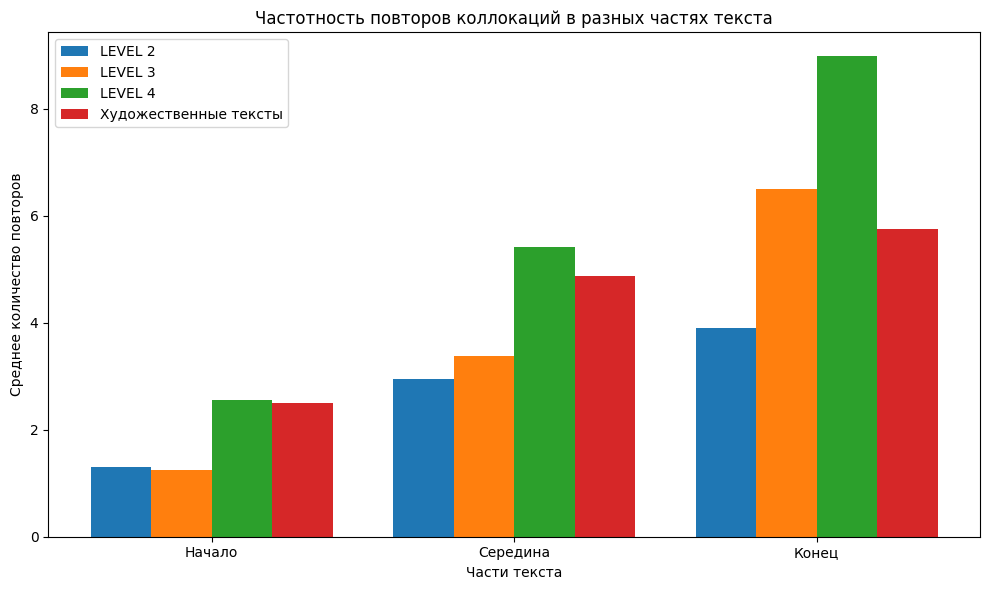


Статистика для LEVEL 2:
  Начало: Среднее = 1.30, Макс = 6, Мин = 0, Всего повторов = 26
  Середина: Среднее = 2.95, Макс = 10, Мин = 0, Всего повторов = 59
  Конец: Среднее = 3.90, Макс = 18, Мин = 0, Всего повторов = 78

Статистика для LEVEL 3:
  Начало: Среднее = 1.25, Макс = 2, Мин = 0, Всего повторов = 10
  Середина: Среднее = 3.38, Макс = 13, Мин = 0, Всего повторов = 27
  Конец: Среднее = 6.50, Макс = 14, Мин = 1, Всего повторов = 52

Статистика для LEVEL 4:
  Начало: Среднее = 2.56, Макс = 9, Мин = 0, Всего повторов = 105
  Середина: Среднее = 5.41, Макс = 14, Мин = 0, Всего повторов = 222
  Конец: Среднее = 8.98, Макс = 27, Мин = 1, Всего повторов = 368

Статистика для Художественные тексты:
  Начало: Среднее = 2.50, Макс = 5, Мин = 0, Всего повторов = 20
  Середина: Среднее = 4.88, Макс = 10, Мин = 0, Всего повторов = 39
  Конец: Среднее = 5.75, Макс = 13, Мин = 1, Всего повторов = 46


In [12]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Функции для обработки текста
def split_into_sections(text, num_sections=3):
    tokens = text.split()
    section_size = max(1, len(tokens) // num_sections)
    return [tokens[i * section_size:(i + 1) * section_size] for i in range(num_sections)]

def count_repeated_bigrams(sections, seen_bigrams):
    repeated_counts = []
    for i, section in enumerate(sections):
        section_bigrams = [f"{section[j]} {section[j+1]}" for j in range(len(section) - 1)]
        section_bigram_count = Counter(section_bigrams)

        # Находим повторяющиеся коллокации в текущей секции
        section_repeats = sum(1 for count in section_bigram_count.values() if count > 1)

        # Добавляем повторяющиеся коллокации, которые уже были в предыдущих секциях
        new_repeats = sum(1 for bigram in section_bigrams if bigram in seen_bigrams)

        total_repeats = section_repeats + new_repeats
        repeated_counts.append(total_repeats)

        # Добавляем биграммы этой секции в видимые для следующих секций
        seen_bigrams.update(section_bigrams)

    return repeated_counts

# Чтение данных
with open('america_texts.json', 'r', encoding='utf-8') as f:
    america_texts = json.load(f)

with open('lib_texts.json', 'r', encoding='utf-8') as f:
    lib_texts = json.load(f)

with open('files_by_levels.txt', 'r', encoding='utf-8') as f:
    files_by_levels = {'LEVEL 2': [], 'LEVEL 3': [], 'LEVEL 4': []}
    current_level = None
    for line in f:
        line = line.strip()
        if line.startswith('LEVEL'):
            current_level = line
        elif line and current_level:
            files_by_levels[current_level].append(line)

# Анализ данных
def analyze_by_level(files, data, num_sections=3):
    all_repeated = np.zeros(num_sections)
    count = 0
    detailed_stats = []

    for file in files:
        if file in data:
            text = data[file]['text']
            sections = split_into_sections(text, num_sections)
            seen_bigrams = set()
            repeated = count_repeated_bigrams(sections, seen_bigrams)
            all_repeated += np.array(repeated)
            count += 1
            detailed_stats.append(repeated)

    return all_repeated / max(count, 1), detailed_stats

# Усреднение по уровням и художественным текстам
num_sections = 3
repeated_results = {}
detailed_stats = {}

for level, files in files_by_levels.items():
    repeated_results[level], detailed_stats[level] = analyze_by_level(files, america_texts, num_sections)

lib_repeated, lib_detailed_stats = analyze_by_level(lib_texts.keys(), lib_texts, num_sections)

# Визуализация результатов
labels = ['Начало', 'Середина', 'Конец']
x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

for i, (level, values) in enumerate(repeated_results.items()):
    ax.bar(x + i * width, values, width, label=level)

ax.bar(x + len(repeated_results) * width, lib_repeated, width, label='Художественные тексты')

ax.set_xlabel('Части текста')
ax.set_ylabel('Среднее количество повторов')
ax.set_title('Частотность повторов коллокаций в разных частях текста')
ax.set_xticks(x + width * len(repeated_results) / 2)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.savefig('repeats_analysis.png')
plt.show()

# Текстовая статистика
def print_stats(stats, label):
    print(f"\nСтатистика для {label}:")
    for i, section in enumerate(['Начало', 'Середина', 'Конец']):
        section_values = [item[i] for item in stats]
        print(f"  {section}: Среднее = {np.mean(section_values):.2f}, Макс = {np.max(section_values)}, Мин = {np.min(section_values)}, Всего повторов = {np.sum(section_values)}")

for level, stats in detailed_stats.items():
    print_stats(stats, level)

print_stats(lib_detailed_stats, 'Художественные тексты')